<a href="https://colab.research.google.com/github/ghiathnj/impacket/blob/master/25_08_2022.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [27]:
import pandas as pd
import numpy as np
import datetime
from datetime import date
from datetime import datetime
import holidays
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import ensemble
from matplotlib import pyplot
import statsmodels.formula.api as smf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error
#np.random.seed(42)
from sklearn.metrics import mean_absolute_percentage_error
import seaborn as sn 
from math import ceil
import calendar

###Resampling the time series data:

### finding the mean of each column's value for the interval of 15 minutes

In [28]:
Energy_df = pd.read_csv('/content/drive/MyDrive/Masterarbeit/data_2019_run12.csv')
Energy_df["time"] = (pd.to_datetime(Energy_df['time']).add(pd.to_timedelta(Energy_df.time, unit='s')).dt.strftime('2019/%m/%d %H:%M:%S'))
Energy_df['time'] = pd.to_datetime(Energy_df['time'])
#Energy_df = Energy_df.set_index('time') 
###Energy_resampled = Energy_df.set_index('time').resample('15T').sum()
Energy_resampled = Energy_df.set_index('time').resample('15T').mean()
#Energy_resapled = Energy_df.resample('15T').sum()
dftest= Energy_resampled
dftest=dftest.reset_index()
dftest

,time,Unnamed: 0,p_eh,p_target,d_abs
0,2019-01-01 00:00:00,7.0,8.453945e+05,-2.000000e+06,2.845395e+06
1,2019-01-01 00:15:00,22.0,-1.644030e+05,-1.789447e+06,1.625044e+06
2,2019-01-01 00:30:00,37.0,-9.675248e+05,-1.578835e+06,6.113105e+05
3,2019-01-01 00:45:00,52.0,-9.364160e+05,-1.126990e+06,1.905739e+05
4,2019-01-01 01:00:00,67.0,-9.697502e+05,-1.018328e+06,5.069407e+04
...,...,...,...,...,...
34939,2019-12-30 22:45:00,524092.0,-1.614645e+06,-1.462639e+06,1.520060e+05
34940,2019-12-30 23:00:00,524107.0,-1.592423e+06,-2.000000e+06,4.075768e+05
34941,2019-12-30 23:15:00,524122.0,-1.592423e+06,-9.591015e+05,6.333217e+05
34942,2019-12-30 23:30:00,524137.0,-1.599086e+06,-1.253964e+06,3.451227e+05


-Augmented dickey-fuller test :
-https://towardsdatascience.com/how-to-remove-non-stationarity-in-time-series-forecasting-563c05c4bfc7

The result of the dickey-fuller test consists of some values like test statistics, p-value critical values, etc. For dataset1 the test statistic value (-2.25) is not less than the critical values (-3.44 , -2.86 , -2.57) at different percentage . In this case, we cannot reject our null hypothesis and conclude that our data is not stationary,

-the ADF test one more times shows that the ADF statistic is much greater than the critical values at different levels, and also the p-value is much greater than 0.05 which signifies, we can fail to reject the null hypothesis at 90%, 95%, and 99% confidence, meaning the time series data is strongly non-stationary.

-When we run adfuller on the original distribution , the p-value was close to 1. After differencing, the p-value is flat 0, suggesting we reject the null and conclude the series is now stationary.

In [3]:
from statsmodels.tsa.stattools import adfuller
result = adfuller(dftest['p_target'])
print('ADF Statistic: {}'.format(result[0]))
print('p-value: {}'.format(result[1]))
print('Critical Values:')
for key, value in result[4].items():
    print('\t{}: {}'.format(key, value))

ADF Statistic: -30.05043568906964
p-value: 0.0
Critical Values:
	1%: -3.4305374238711472
	5%: -2.8616228367115264
	10%: -2.566814091379453


In [29]:
Energy_df

,Unnamed: 0,time,p_eh,p_target,d_abs
0,0,2019-01-01 00:00:00,7.725664e+05,-2.000000e+06,2.772566e+06
1,1,2019-01-01 00:01:00,4.089311e+05,-2.000000e+06,2.408931e+06
2,2,2019-01-01 00:02:00,4.089311e+05,-2.000000e+06,2.408931e+06
3,3,2019-01-01 00:03:00,6.255978e+05,-2.000000e+06,2.625598e+06
4,4,2019-01-01 00:04:00,9.892331e+05,-2.000000e+06,2.989233e+06
...,...,...,...,...,...
524155,524155,2019-12-30 23:55:00,-1.536857e+06,-1.485311e+06,5.154631e+04
524156,524156,2019-12-30 23:56:00,-1.570190e+06,-1.485311e+06,8.487964e+04
524157,524157,2019-12-30 23:57:00,-1.636857e+06,-1.485311e+06,1.515463e+05
524158,524158,2019-12-30 23:58:00,-1.603524e+06,-1.485311e+06,1.182130e+05


# Time Series Preprocessing and Feature Engineering
A fundamental assumption of autoregressive models is that we can use past values to predict future ones. So, we need to create features to represent these past values. We call these lag variables, and they lag behind the actual time series by 1, 2, 3, or (many) more time steps.

Use the shift() method in pandas to create lagged variables.


https://h2o.ai/blog/an-introduction-to-time-series-modeling-time-series-preprocessing-and-feature-engineering/

In [30]:
dftest['t-1'] = dftest['d_abs'].shift(1)
dftest['t-2'] = dftest['d_abs'].shift(2)
dftest['t-3'] = dftest['d_abs'].shift(3)
#lagged_feature_cols = ['t-3', 't-2', 't-1']
# Drop first 3 rows due to NaNs
#df_lagged = dftest.loc[3:,lagged_feature_cols +['d_abs']]
# Create feature df to use for aggregation calculations
#df_lagged_features = dftest.loc[:, lagged_feature_cols]
# Create aggregated features
#df_lagged['max'] = df_lagged_features.aggregate(np.max, axis=1)
#df_lagged['min'] = df_lagged_features.aggregate(np.min, axis=1)
#df_lagged
#dftest=dftest.merge(df_lagged[['max','min']],how='left',left_index=True,right_index=True)
dftest
#df_lagged

,time,Unnamed: 0,p_eh,p_target,d_abs,t-1,t-2,t-3
0,2019-01-01 00:00:00,7.0,8.453945e+05,-2.000000e+06,2.845395e+06,NaN,NaN,NaN
1,2019-01-01 00:15:00,22.0,-1.644030e+05,-1.789447e+06,1.625044e+06,2.845395e+06,NaN,NaN
2,2019-01-01 00:30:00,37.0,-9.675248e+05,-1.578835e+06,6.113105e+05,1.625044e+06,2.845395e+06,NaN
3,2019-01-01 00:45:00,52.0,-9.364160e+05,-1.126990e+06,1.905739e+05,6.113105e+05,1.625044e+06,2.845395e+06
4,2019-01-01 01:00:00,67.0,-9.697502e+05,-1.018328e+06,5.069407e+04,1.905739e+05,6.113105e+05,1.625044e+06
...,...,...,...,...,...,...,...,...
34939,2019-12-30 22:45:00,524092.0,-1.614645e+06,-1.462639e+06,1.520060e+05,4.039933e+05,1.302634e+05,1.331115e+05
34940,2019-12-30 23:00:00,524107.0,-1.592423e+06,-2.000000e+06,4.075768e+05,1.520060e+05,4.039933e+05,1.302634e+05
34941,2019-12-30 23:15:00,524122.0,-1.592423e+06,-9.591015e+05,6.333217e+05,4.075768e+05,1.520060e+05,4.039933e+05
34942,2019-12-30 23:30:00,524137.0,-1.599086e+06,-1.253964e+06,3.451227e+05,6.333217e+05,4.075768e+05,1.520060e+05


In [31]:
#extract important features
##https://www.geeksforgeeks.org/python-holidays-library/

def get_season(month):

    if month =='September' or month =='October' or month =='November':
      Season= 'Autumn'
    elif month =='December' or month == 'January' or month =='February':
      Season= 'Winter'
    elif month =='March' or month =='April' or month =='May':
      Season= 'Spring'
    else:
      Season = 'Summer'

    return Season
#------------------------------------------------------


dftest['Dates'] = pd.to_datetime(dftest['time']).dt.date
#dftest['TimeInHMS'] = pd.to_datetime(dftest['time']).dt.time
dftest['Hour']= pd.to_datetime(dftest['time']).dt.hour
dftest['minute']= pd.to_datetime(dftest['time']).dt.minute
#dftest['second']= pd.to_datetime(dftest['time']).dt.second
dftest['Day'] = pd.to_datetime(dftest['time']).dt.day_name()
dftest['DayOfYear'] = pd.to_datetime(dftest['time']).dt.dayofyear
dftest['Month'] = pd.to_datetime(dftest['time']).dt.month_name()
dftest['MonthInNum'] = pd.to_datetime(dftest['time']).dt.month
dftest['Quarter'] = pd.to_datetime(dftest['time']).dt.quarter
dftest['Year'] = pd.to_datetime(dftest['time']).dt.year
dftest['Weekday'] = pd.to_datetime(dftest['time']).dt.weekday
dftest['DaysOfMonth'] = pd.to_datetime(dftest['time']).dt.day
#dftest['WeekOfMonth'] = week_of_month(dftest['time'])
#The weekday() function of date class in datetime module, returns an integer between 0(monday) and 6(sunday)
dftest['Seasons'] = dftest['Month'].apply(lambda x: get_season(x))
dftest['Weekend'] = dftest['Weekday'].apply(lambda x: x>=5).astype('int')
dftest['WeekOfYear'] = pd.to_datetime(dftest['time']).dt.week
dftest['Holiday'] = pd.to_datetime(dftest['time']).dt.date.apply(lambda x: holidays.CountryHoliday('DE',prov='BW').get(x)).values.astype('bool').astype('int')
dftest['DayAheadWeekend'] = dftest['Weekday'].apply(lambda x: x==4).astype('int')
dftest['DayAfterWeekend'] = dftest['Weekday'].apply(lambda x: x==0).astype('int')
dftest

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:36: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.


,time,Unnamed: 0,p_eh,p_target,d_abs,t-1,t-2,t-3,Dates,Hour,...,Quarter,Year,Weekday,DaysOfMonth,Seasons,Weekend,WeekOfYear,Holiday,DayAheadWeekend,DayAfterWeekend
0,2019-01-01 00:00:00,7.0,8.453945e+05,-2.000000e+06,2.845395e+06,NaN,NaN,NaN,2019-01-01,0,...,1,2019,1,1,Winter,0,1,1,0,0
1,2019-01-01 00:15:00,22.0,-1.644030e+05,-1.789447e+06,1.625044e+06,2.845395e+06,NaN,NaN,2019-01-01,0,...,1,2019,1,1,Winter,0,1,1,0,0
2,2019-01-01 00:30:00,37.0,-9.675248e+05,-1.578835e+06,6.113105e+05,1.625044e+06,2.845395e+06,NaN,2019-01-01,0,...,1,2019,1,1,Winter,0,1,1,0,0
3,2019-01-01 00:45:00,52.0,-9.364160e+05,-1.126990e+06,1.905739e+05,6.113105e+05,1.625044e+06,2.845395e+06,2019-01-01,0,...,1,2019,1,1,Winter,0,1,1,0,0
4,2019-01-01 01:00:00,67.0,-9.697502e+05,-1.018328e+06,5.069407e+04,1.905739e+05,6.113105e+05,1.625044e+06,2019-01-01,1,...,1,2019,1,1,Winter,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34939,2019-12-30 22:45:00,524092.0,-1.614645e+06,-1.462639e+06,1.520060e+05,4.039933e+05,1.302634e+05,1.331115e+05,2019-12-30,22,...,4,2019,0,30,Winter,0,1,0,0,1
34940,2019-12-30 23:00:00,524107.0,-1.592423e+06,-2.000000e+06,4.075768e+05,1.520060e+05,4.039933e+05,1.302634e+05,2019-12-30,23,...,4,2019,0,30,Winter,0,1,0,0,1
34941,2019-12-30 23:15:00,524122.0,-1.592423e+06,-9.591015e+05,6.333217e+05,4.075768e+05,1.520060e+05,4.039933e+05,2019-12-30,23,...,4,2019,0,30,Winter,0,1,0,0,1
34942,2019-12-30 23:30:00,524137.0,-1.599086e+06,-1.253964e+06,3.451227e+05,6.333217e+05,4.075768e+05,1.520060e+05,2019-12-30,23,...,4,2019,0,30,Winter,0,1,0,0,1


In [32]:
from datetime import datetime as dt
from math import ceil
#dftest['Date'] = pd.to_datetime(dftest['Year'].astype(str) + '-' + dftest['Week'].astype(str) + '-1', format='%Y-%W-%w')
calendar.setfirstweekday(0)

def week_of_month(dt):
    """ Returns the week of the month for the specified date.
    """

    first_day = dt.replace(day=1)

    dom = dt.day
    adjusted_dom = dom + first_day.weekday()

    return int(ceil(adjusted_dom/7.0))
dftest['WeekOfMonth'] = dftest['time'].apply(week_of_month)
#------------------------------------------------------
#Another way to find the week of the month

#calendar.setfirstweekday(0)
#def get_week_of_month(year, month, day):
 #   x = np.array(calendar.monthcalendar(year, month))
  #  week_of_month = np.where(x==day)[0][0] + 1
  #  return(week_of_month)
#get_week_of_month(2019,12,30)

In [8]:
#dftest['Month'].unique()

In [9]:
#from sklearn.preprocessing import LabelEncoder
#le = LabelEncoder()
#le.fit_transform(dftest['Month'].unique())

In [33]:
from sklearn.preprocessing import LabelEncoder
#dftest = dftest.drop(['Unnamed: 0'], axis = 1)
categorical_features = [ 'Seasons']
le = LabelEncoder()

# Convert the variables to numerical
for i in range(1):
    new = le.fit_transform(dftest[categorical_features[i]])
    dftest[categorical_features[i]] = new

df_train=dftest
dftest.head()

,time,Unnamed: 0,p_eh,p_target,d_abs,t-1,t-2,t-3,Dates,Hour,...,Year,Weekday,DaysOfMonth,Seasons,Weekend,WeekOfYear,Holiday,DayAheadWeekend,DayAfterWeekend,WeekOfMonth
0,2019-01-01 00:00:00,7.0,845394.513426,-2.000000e+06,2.845395e+06,NaN,NaN,NaN,2019-01-01,0,...,2019,1,1,3,0,1,1,0,0,1
1,2019-01-01 00:15:00,22.0,-164403.031333,-1.789447e+06,1.625044e+06,2.845395e+06,NaN,NaN,2019-01-01,0,...,2019,1,1,3,0,1,1,0,0,1
2,2019-01-01 00:30:00,37.0,-967524.787811,-1.578835e+06,6.113105e+05,1.625044e+06,2.845395e+06,NaN,2019-01-01,0,...,2019,1,1,3,0,1,1,0,0,1
3,2019-01-01 00:45:00,52.0,-936416.036730,-1.126990e+06,1.905739e+05,6.113105e+05,1.625044e+06,2.845395e+06,2019-01-01,0,...,2019,1,1,3,0,1,1,0,0,1
4,2019-01-01 01:00:00,67.0,-969750.190664,-1.018328e+06,5.069407e+04,1.905739e+05,6.113105e+05,1.625044e+06,2019-01-01,1,...,2019,1,1,3,0,1,1,0,0,1


In [11]:
gkk = df_train.groupby(['Seasons', 'Month'],)
gkk.first()

time  Unnamed: 0          p_eh      p_target  \
Seasons Month                                                          
0       November  2019-11-01    437767.0  8.570936e+05 -2.724545e+05   
        October   2019-10-01    393127.0 -3.373276e+04 -1.931305e+06   
        September 2019-09-01    349927.0  8.566754e+05  2.194058e+06   
1       April     2019-04-01    129607.0  9.787100e+05 -1.996266e+06   
        March     2019-03-01     84967.0  1.120290e+06 -6.119118e+05   
        May       2019-05-01    172807.0  1.401077e+06  3.026000e+06   
2       August    2019-08-01    305287.0  6.021203e+05 -1.737728e+06   
        July      2019-07-01    260647.0  5.116442e+05 -1.664542e+06   
        June      2019-06-01    217447.0 -3.547342e+05 -1.060913e+06   
3       December  2019-12-01    480967.0  7.726205e+05  2.718525e+05   
        February  2019-02-01     44647.0 -6.025535e+05 -1.331028e+06   
        January   2019-01-01         7.0  8.453945e+05 -2.000000e+06   

                          d_abs           t-1           t-2           t-3  \
Seasons Month                                                               
0       November   1.129548e+06  7.525312e+05  8.798237e+05  8.256442e+05   
        October    1.897572e+06  1.899072e+06  1.199119e+06  1.209203e+06   
        September  1.337383e+06  7.810571e+05  5.914322e+05  8.783789e+05   
1       April      2.974976e+06  1.292495e+06  1.107116e+06  1.050188e+06   
        March      1.739926e+06  1.578252e+06  1.692056e+06  1.602651e+06   
        May        1.624923e+06  2.353385e+05  2.129606e+05  2.768126e+05   
2       August     2.339849e+06  1.942075e+06  1.749429e+06  4.905944e+05   
        July       2.176186e+06  7.500437e+05  9.107815e+05  8.352906e+05   
        June       7.061787e+05  2.005560e+06  2.004008e+06  1.074819e+06   
3       December   5.111339e+05  3.258243e+05  5.497292e+05  6.097398e+05   
        February   7.975816e+05  1.285650e+06  1.285135e+06  1.231879e+06   
        January    2.845395e+06  2.845395e+06  2.845395e+06  2.845395e+06   

                        Dates  Hour  ...  Quarter  Year  Weekday  DaysOfMonth  \
Seasons Month                        ...                                        
0       November   2019-11-01     0  ...        4  2019        4            1   
        October    2019-10-01     0  ...        4  2019        1            1   
        September  2019-09-01     0  ...        3  2019        6            1   
1       April      2019-04-01     0  ...        2  2019        0            1   
        March      2019-03-01     0  ...        1  2019        4            1   
        May        2019-05-01     0  ...        2  2019        2            1   
2       August     2019-08-01     0  ...        3  2019        3            1   
        July       2019-07-01     0  ...        3  2019        0            1   
        June       2019-06-01     0  ...        2  2019        5            1   
3       December   2019-12-01     0  ...        4  2019        6            1   
        February   2019-02-01     0  ...        1  2019        4            1   
        January    2019-01-01     0  ...        1  2019        1            1   

                   Weekend  WeekOfYear  Holiday  DayAheadWeekend  \
Seasons Month                                                      
0       November         0          44        1                1   
        October          0          40        0                0   
        September        1          35        0                0   
1       April            0          14        0                0   
        March            0           9        0                1   
        May              0          18        1                0   
2       August           0          31        0                0   
        July             0          27        0                0   
        June             1          22        0                0   
3       December         1          48        0      

In [34]:
Seasons_W  = df_train.query(' Seasons==3')
Seasons_F  = df_train.query(' Seasons==1')
Seasons_S = df_train.query(' Seasons==2')
Seasons_H = df_train.query(' Seasons==0')
Seasons_W

,time,Unnamed: 0,p_eh,p_target,d_abs,t-1,t-2,t-3,Dates,Hour,...,Year,Weekday,DaysOfMonth,Seasons,Weekend,WeekOfYear,Holiday,DayAheadWeekend,DayAfterWeekend,WeekOfMonth
0,2019-01-01 00:00:00,7.0,8.453945e+05,-2.000000e+06,2.845395e+06,NaN,NaN,NaN,2019-01-01,0,...,2019,1,1,3,0,1,1,0,0,1
1,2019-01-01 00:15:00,22.0,-1.644030e+05,-1.789447e+06,1.625044e+06,2.845395e+06,NaN,NaN,2019-01-01,0,...,2019,1,1,3,0,1,1,0,0,1
2,2019-01-01 00:30:00,37.0,-9.675248e+05,-1.578835e+06,6.113105e+05,1.625044e+06,2.845395e+06,NaN,2019-01-01,0,...,2019,1,1,3,0,1,1,0,0,1
3,2019-01-01 00:45:00,52.0,-9.364160e+05,-1.126990e+06,1.905739e+05,6.113105e+05,1.625044e+06,2.845395e+06,2019-01-01,0,...,2019,1,1,3,0,1,1,0,0,1
4,2019-01-01 01:00:00,67.0,-9.697502e+05,-1.018328e+06,5.069407e+04,1.905739e+05,6.113105e+05,1.625044e+06,2019-01-01,1,...,2019,1,1,3,0,1,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34939,2019-12-30 22:45:00,524092.0,-1.614645e+06,-1.462639e+06,1.520060e+05,4.039933e+05,1.302634e+05,1.331115e+05,2019-12-30,22,...,2019,0,30,3,0,1,0,0,1,6
34940,2019-12-30 23:00:00,524107.0,-1.592423e+06,-2.000000e+06,4.075768e+05,1.520060e+05,4.039933e+05,1.302634e+05,2019-12-30,23,...,2019,0,30,3,0,1,0,0,1,6
34941,2019-12-30 23:15:00,524122.0,-1.592423e+06,-9.591015e+05,6.333217e+05,4.075768e+05,1.520060e+05,4.039933e+05,2019-12-30,23,...,2019,0,30,3,0,1,0,0,1,6
34942,2019-12-30 23:30:00,524137.0,-1.599086e+06,-1.253964e+06,3.451227e+05,6.333217e+05,4.075768e+05,1.520060e+05,2019-12-30,23,...,2019,0,30,3,0,1,0,0,1,6


In [13]:
#import random
#list_of_datasets = [Seasons_W, Seasons_S, Seasons_F,Seasons_H]
#df1 = pd.DataFrame(columns=df_train.columns) 
#df2 = pd.DataFrame(columns=df_train.columns) 
#for i in list_of_datasets:
#  test_list=(i.DaysOfMonth[i['DaysOfMonth'] <= 29]).unique()
#  test_list_rand=random.sample(list(test_list),6)# 18 is 20 procent of the three months
#  df_for_test=i[i.DaysOfMonth.isin(test_list_rand)]
#  df_for_train=i[~(i.DaysOfMonth.isin(test_list_rand))] 
#  df2 = df2.append(df_for_train).sort_values('time')
#  df1 = df1.append(df_for_test).sort_values('time')
#df2
#df1.to_csv('/content/drive/MyDrive/Masterarbeit/test', index=False)
#df2.to_csv('/content/drive/MyDrive/Masterarbeit/train', index=False)


In [42]:
import random
list_of_datasets = [Seasons_W, Seasons_S, Seasons_F,Seasons_H]
df_for_testing = pd.DataFrame(columns=df_train.columns) 
df_for_training = pd.DataFrame(columns=df_train.columns) 
for i in list_of_datasets:
  test_list=(i.DaysOfMonth[i['DaysOfMonth'] <= 29]).unique()
  test_list_rand=random.sample(list(test_list),6)# 18 is 20 procent of the three months
  df_for_test_check=i[i.DaysOfMonth.isin(test_list_rand)]
  df_for_train_check=i[~(i.DaysOfMonth.isin(test_list_rand))] 

###check that not all day are workday or weekend 
## isin() methods return Boolean
# Dataframe of given Dimension
# first any() will return boolean series
# and 2nd any() will return single bool value
#--------------------------------#
##proportion  of item occurrences
# the proportion of Weekend with value equal '1' between 25 and  30 (30 procent der gesammten Daten)

proportion_test =round(((df_for_test_check.groupby('Weekend').size()/df_for_test_check['Weekend'].count())*100).iloc[1])
proportion_train =round(((df_for_train_check.groupby('Weekend').size()/df_for_train_check['Weekend'].count())*100).iloc[1])

##range(start, stop) to create a range of integers from start up to stop-1.
if (df_for_test_check['Weekend'].isin([0,1]).any().any()) and (proportion_test in range(20, 31)):
    df_for_testing = df_for_testing.append(df_for_test_check).sort_values('time')
else:
  while ~(proportion_test in range(25, 31)): 
   test_list=(i.DaysOfMonth[i['DaysOfMonth'] <= 29]).unique()
   test_list_rand=random.sample(list(test_list),6)# 18 is 20 procent of the three months
   df_for_test_check=i[i.DaysOfMonth.isin(test_list_rand)]
   proportion_test =round(((df_for_test_check.groupby('Weekend').size()/df_for_test_check['Weekend'].count())*100).iloc[1])
  df_for_testing = df_for_testing.append(df_for_test_check).sort_values('time')

if (df_for_train_check.Weekend.isin([0,1]).any().any()) and ( proportion_train in range(20, 31)):
    df_for_training = df_for_training.append(df_for_train_check).sort_values('time')
else:
  while ~(proportion_test in range(25, 31)): 
    test_list=(i.DaysOfMonth[i['DaysOfMonth'] <= 29]).unique()
    test_list_rand=random.sample(list(test_list),6)# 18 is 20 procent of the three months
    df_for_train_check=i[~(i.DaysOfMonth.isin(test_list_rand))]
    proportion_train =round(((df_for_train_check.groupby('Weekend').size()/df_for_train_check['Weekend'].count())*100).iloc[1]) 
  df_for_training = df_for_training.append(df_for_train_check).sort_values('time')
#df1=df1.reset_index()
#df2=df2.reset_index()
df_for_testing.to_csv('/content/drive/MyDrive/Masterarbeit/test', index=False)
df_for_training.to_csv('/content/drive/MyDrive/Masterarbeit/train', index=False)
df_for_testing

,time,Unnamed: 0,p_eh,p_target,d_abs,t-1,t-2,t-3,Dates,Hour,...,Year,Weekday,DaysOfMonth,Seasons,Weekend,WeekOfYear,Holiday,DayAheadWeekend,DayAfterWeekend,WeekOfMonth
23904,2019-09-07 00:00:00,358567.0,2.437728e+06,-1.984319e+06,4.422047e+06,2.377618e+06,2.395957e+06,2.286358e+06,2019-09-07,0,...,2019,5,7,0,1,36,0,0,0,2
23905,2019-09-07 00:15:00,358582.0,5.036447e+05,-1.964554e+06,2.468199e+06,4.422047e+06,2.377618e+06,2.395957e+06,2019-09-07,0,...,2019,5,7,0,1,36,0,0,0,2
23906,2019-09-07 00:30:00,358597.0,3.164837e+05,-1.975812e+06,2.292296e+06,2.468199e+06,4.422047e+06,2.377618e+06,2019-09-07,0,...,2019,5,7,0,1,36,0,0,0,2
23907,2019-09-07 00:45:00,358612.0,1.364811e+05,-2.000000e+06,2.136481e+06,2.292296e+06,2.468199e+06,4.422047e+06,2019-09-07,0,...,2019,5,7,0,1,36,0,0,0,2
23908,2019-09-07 01:00:00,358627.0,2.231492e+05,-1.989565e+06,2.212714e+06,2.136481e+06,2.292296e+06,2.468199e+06,2019-09-07,1,...,2019,5,7,0,1,36,0,0,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31867,2019-11-28 22:45:00,478012.0,-4.546786e+05,-1.822776e+06,1.368098e+06,1.365180e+06,1.390946e+06,1.250114e+06,2019-11-28,22,...,2019,3,28,0,0,48,0,0,0,5
31868,2019-11-28 23:00:00,478027.0,-3.496488e+05,-1.907132e+06,1.557483e+06,1.368098e+06,1.365180e+06,1.390946e+06,2019-11-28,23,...,2019,3,28,0,0,48,0,0,0,5
31869,2019-11-28 23:15:00,478042.0,-3.496488e+05,-1.928830e+06,1.579181e+06,1.557483e+06,1.368098e+06,1.365180e+06,2019-11-28,23,...,2019,3,28,0,0,48,0,0,0,5
31870,2019-11-28 23:30:00,478057.0,-3.496488e+05,-2.000000e+06,1.650351e+06,1.579181e+06,1.557483e+06,1.368098e+06,2019-11-28,23,...,2019,3,28,0,0,48,0,0,0,5


In [43]:
print(round(df_for_training['Weekend'].value_counts(normalize=True) * 100))
print(round(df_for_testing['Weekend'].value_counts(normalize=True) * 100))

0    71.0
1    29.0
Name: Weekend, dtype: float64
0    72.0
1    28.0
Name: Weekend, dtype: float64


In [40]:
from sklearn import svm
from sklearn.svm import SVR
X_train= df_for_training[['Hour','Weekday','Weekend','minute','DayAheadWeekend','DayAfterWeekend']]
y_train = df_for_training['d_abs']

X_test= df_for_testing[['Hour','Weekday','Weekend','minute','DayAheadWeekend','DayAfterWeekend']]
y_test = df_for_testing['d_abs']
#svr_poly = SVR(kernel="poly", C=100, gamma="auto", degree=3, epsilon=0.1, coef0=1)
#svr_rbf = SVR(kernel="rbf", C=100, gamma=0.1, epsilon=0.1)
svr_lin = SVR(kernel="linear", C=100, gamma="auto")
#regr = svm.SVR()
svr_lin.fit(X_train,y_train)

y_preds=svr_lin.predict(X_test)
from sklearn import metrics
print('Mean absolute percentage error:', mean_absolute_percentage_error(y_test,y_preds))
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_preds))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_preds))
score=np.sqrt(metrics.mean_squared_error(y_test, y_preds))
print(f'Root Mean Squared Error:{score:0.2f}')

Mean absolute percentage error: 6.561695792781239
Mean Absolute Error: 514415.71001591854
Mean Squared Error: 458695067697.12445
Root Mean Squared Error:677270.31


In [ ]:
from sklearn.datasets import make_regression
from sklearn.ensemble import GradientBoostingRegressor

X_train= df_for_training[['Hour','Weekday','Weekend','minute','DayAheadWeekend','DayAfterWeekend']]
y_train = df_for_training['d_abs']

X_test= df_for_testing[['Hour','Weekday','Weekend','minute','DayAheadWeekend','DayAfterWeekend']]
y_test = df_for_testing['d_abs']

xgbr = GradientBoostingRegressor(n_estimators=100)
xgbr.fit(X_train,y_train)

y_preds=xgbr.predict(X_test)
from sklearn import metrics
print('Mean absolute percentage error:', mean_absolute_percentage_error(y_test,y_preds))
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_preds))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_preds))
score=np.sqrt(metrics.mean_squared_error(y_test, y_preds))
print(f'Root Mean Squared Error:{score:0.2f}')

Mean absolute percentage error: 2.9054348872259266
Mean Absolute Error: 462526.4130823246
Mean Squared Error: 337056568197.5227
Root Mean Squared Error:580565.73


In [46]:
#X_train= df2[['Seasons','MonthInNum','minute','DayOfYear','Weekday','Hour','Holiday']]
#y_train = df2['d_abs']

#X_test= df1[['Seasons','MonthInNum','minute','DayOfYear','Weekday','Hour','Holiday']]
#y_test = df1['d_abs']

#X_train= df_for_training[['Hour','Weekday','Weekend','minute','DayAheadWeekend','DayAfterWeekend','t-1','t-2','t-3']]
#y_train = df_for_training['d_abs']

#X_test= df_for_testing[['Hour','Weekday','Weekend','minute','DayAheadWeekend','DayAfterWeekend','t-1','t-2','t-3']]
#y_test = df_for_testing['d_abs']

X_train= df_for_training[['Hour','Weekday','Weekend','minute','DayAheadWeekend','DayAfterWeekend','t-1','t-2','t-3']]
y_train = df_for_training['d_abs']

X_test= df_for_testing[['Hour','Weekday','Weekend','minute','DayAheadWeekend','DayAfterWeekend','t-1','t-2','t-3']]
y_test = df_for_testing['d_abs']


model= RandomForestRegressor(n_estimators=100)

model.fit(X_train,y_train)
#y_test
df_for_testing['prediction']=model.predict(X_test)

y_preds=model.predict(X_test)
from sklearn import metrics
print('Mean absolute percentage error:', mean_absolute_percentage_error(y_test,y_preds))
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_preds))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_preds))
score=np.sqrt(metrics.mean_squared_error(y_test, y_preds))
print(f'Root Mean Squared Error:{score:0.2f}')

Mean absolute percentage error: 1.4759341367481307
Mean Absolute Error: 259882.90029416257
Mean Squared Error: 144229511978.87653
Root Mean Squared Error:379775.61


In [51]:
df_train=df_train.merge(df_for_testing[['prediction']],how='left',left_index=True,right_index=True)
#df_train.prediction.value_counts()

In [52]:
df_train=df_train.dropna()

calculating the error by substracting the target value from the predicted one, and then take the absolute value from this so negativ and positive value are not mattter, so it will give us general error value for each of our prediction

In [53]:
df_for_testing['error']=np.abs(df_for_testing['d_abs']-df_for_testing['prediction'])
#looking at the worse and best predicted days:
#this will give us the average error for each day that we have predicted 
#(ascending =False)==>then we can see by showing the results where are the worse predicted days
#(ascending =False)== the best prediction

df_for_testing.groupby(['time'])['error'].mean().sort_values(ascending =False).head(5)

#df1.groupby('Dates')['error'].mean().sort_values(ascending =True).head(5)


time
2019-09-07 00:00:00    2.267612e+06
2019-10-13 00:15:00    1.957267e+06
2019-11-28 00:00:00    1.891876e+06
2019-10-25 00:00:00    1.764885e+06
2019-09-28 00:00:00    1.693391e+06
Name: error, dtype: float64

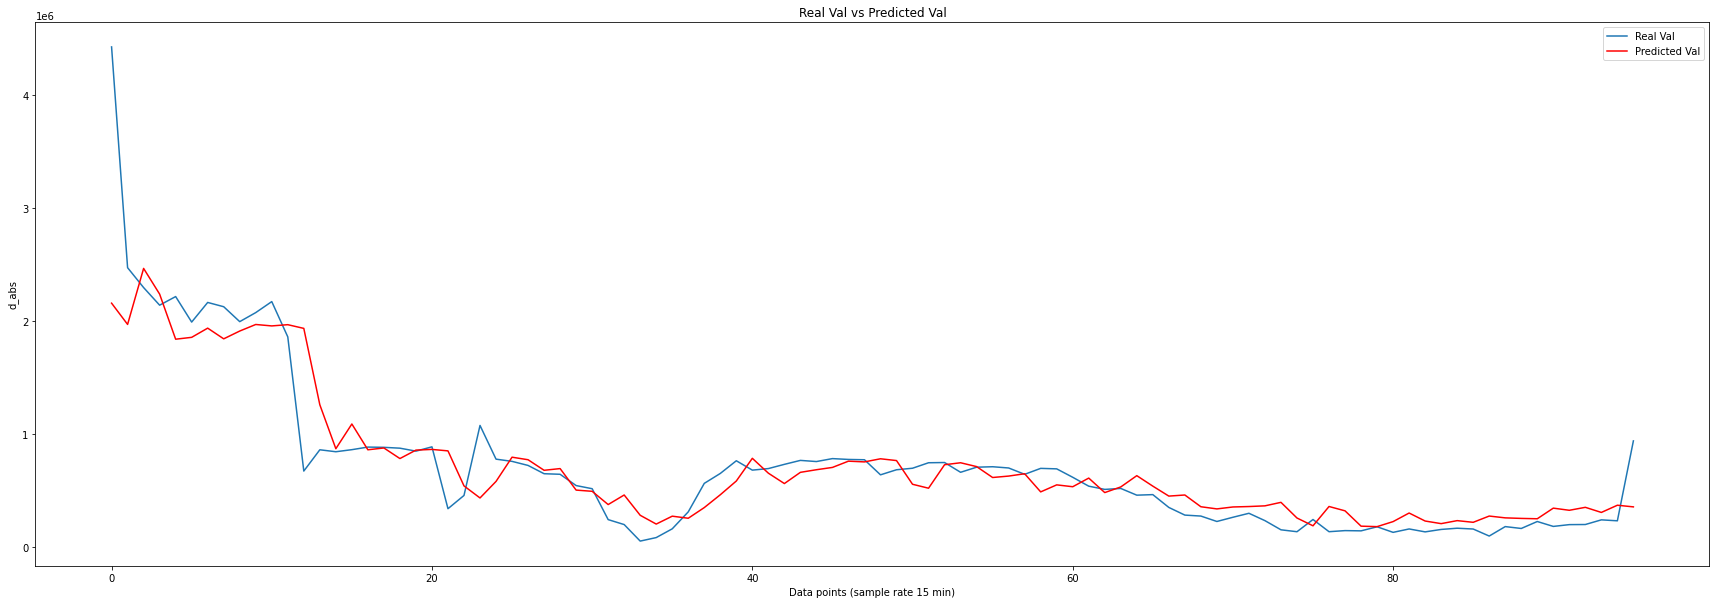

In [54]:

  index = np.arange(0,96)
  fig, ax = plt.subplots(1,1,figsize=(30,10))
  plt.plot(index,y_test[0:96], label = 'Real Val')
  plt.plot(index,y_preds[0:96], label = 'Predicted Val',color='red')
  plt.title('Real Val vs Predicted Val')
  plt.xlabel('Data points (sample rate 15 min)')
  plt.ylabel('d_abs')
  plt.legend()
  plt.show()

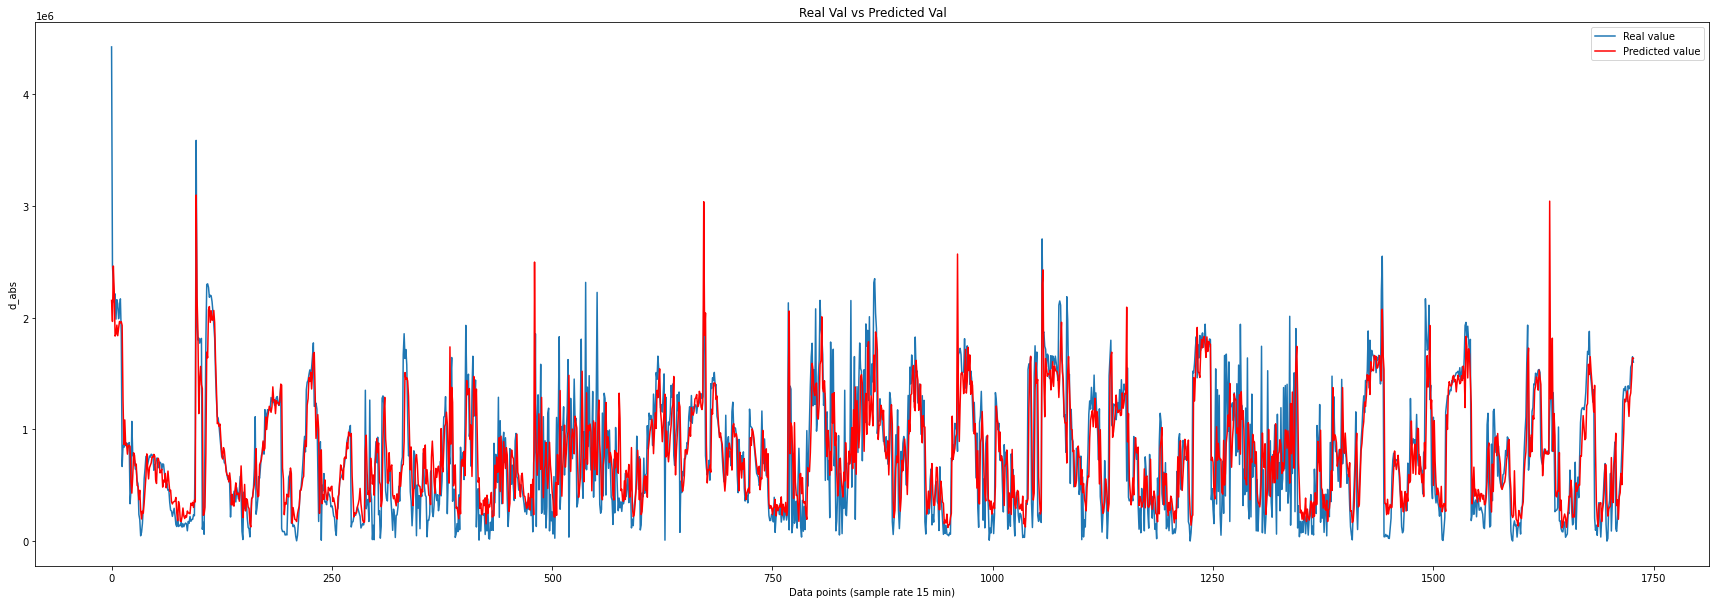

In [55]:

  index = np.arange(len(y_test))
  fig, ax = plt.subplots(1,1,figsize=(30,10))
  plt.plot(index,y_test, label = 'Real value')
  plt.plot(index,y_preds, label = 'Predicted value',color='red')
  plt.title('Real Val vs Predicted Val')
  plt.xlabel('Data points (sample rate 15 min)')
  plt.ylabel('d_abs')
  plt.legend()
  plt.show()
  

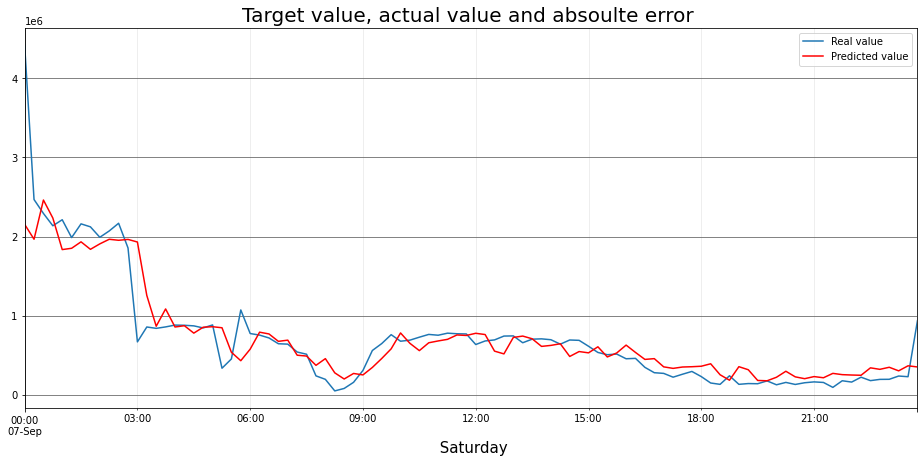

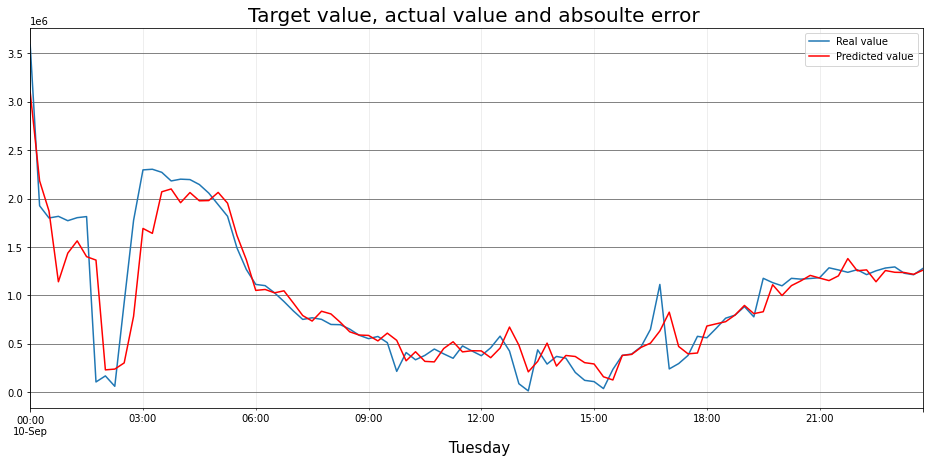

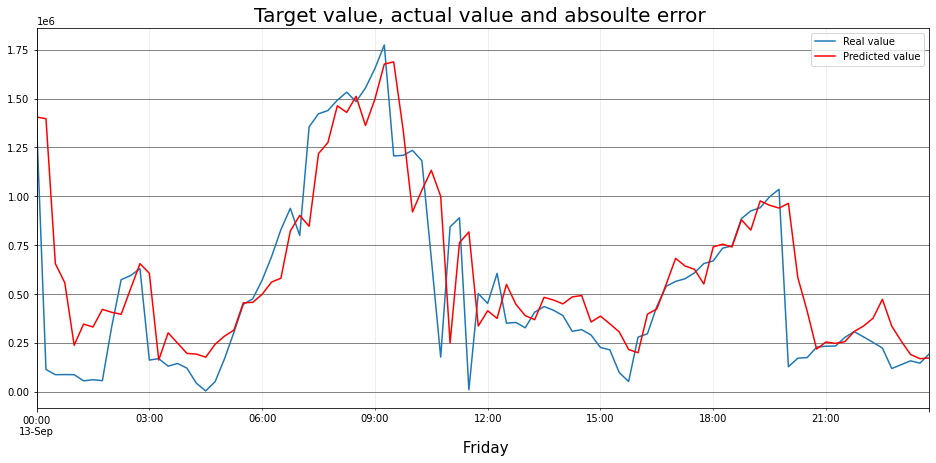

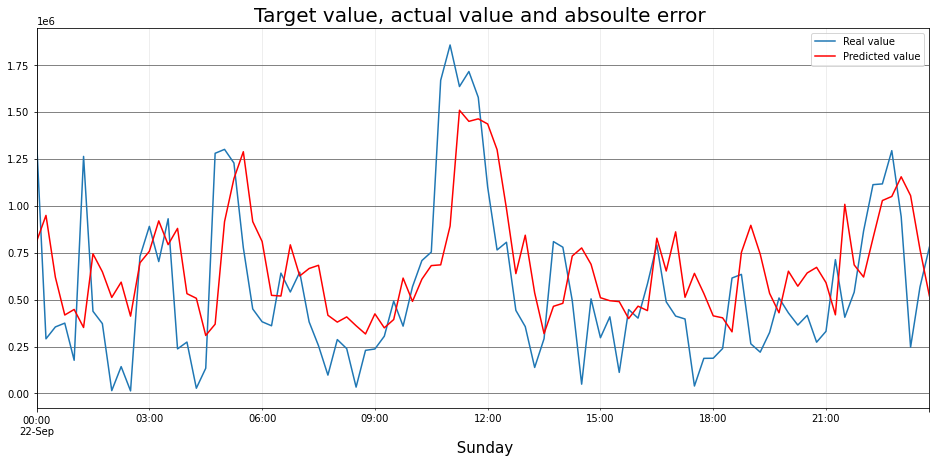

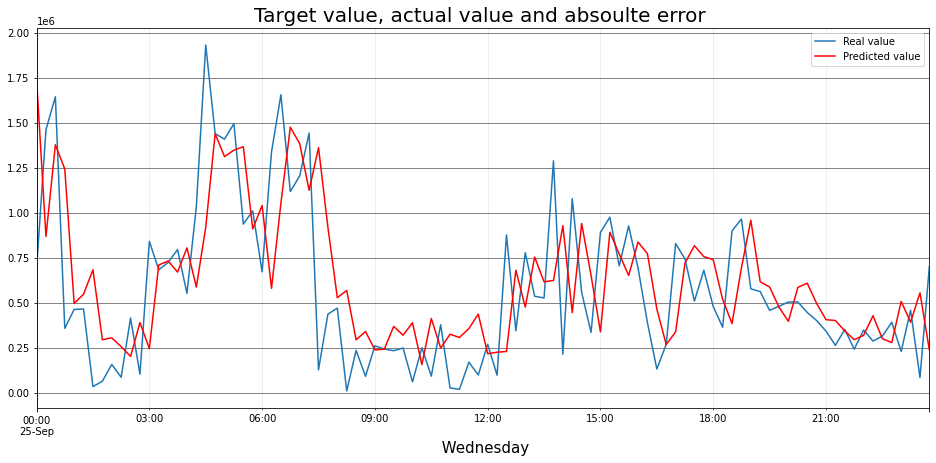

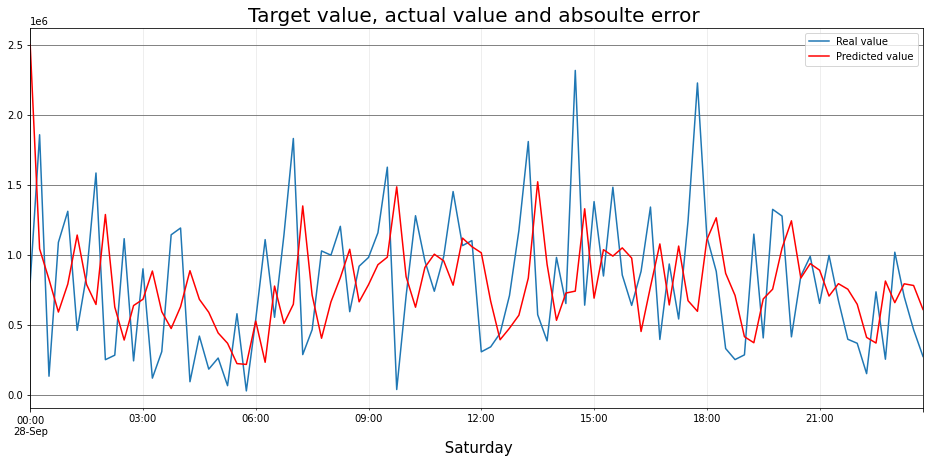

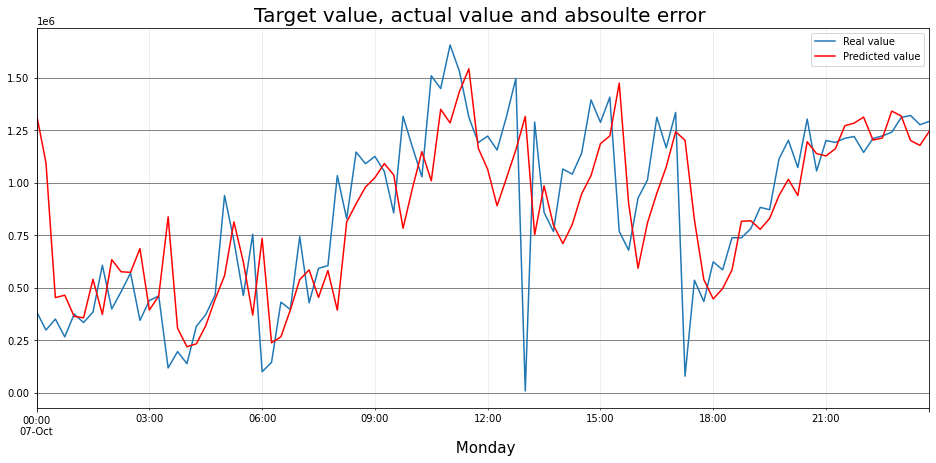

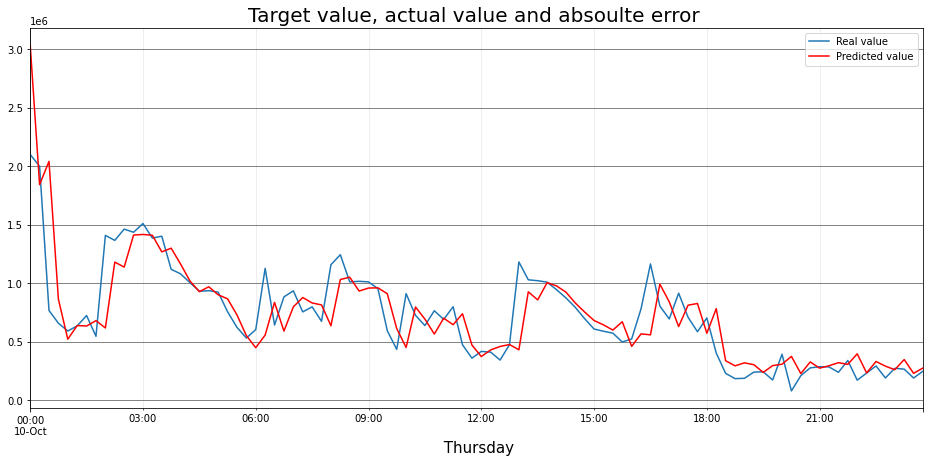

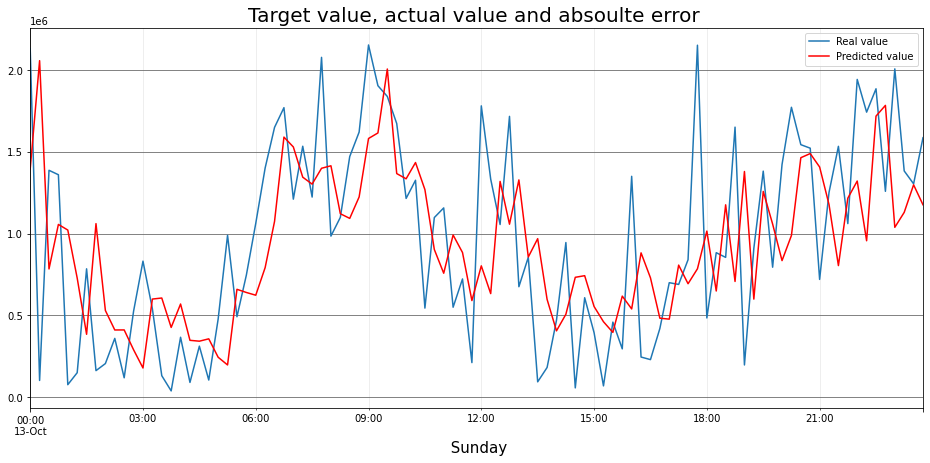

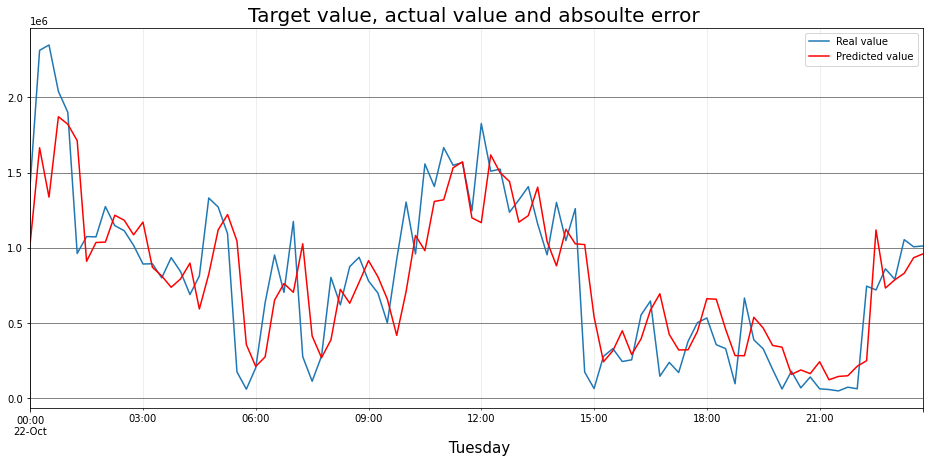

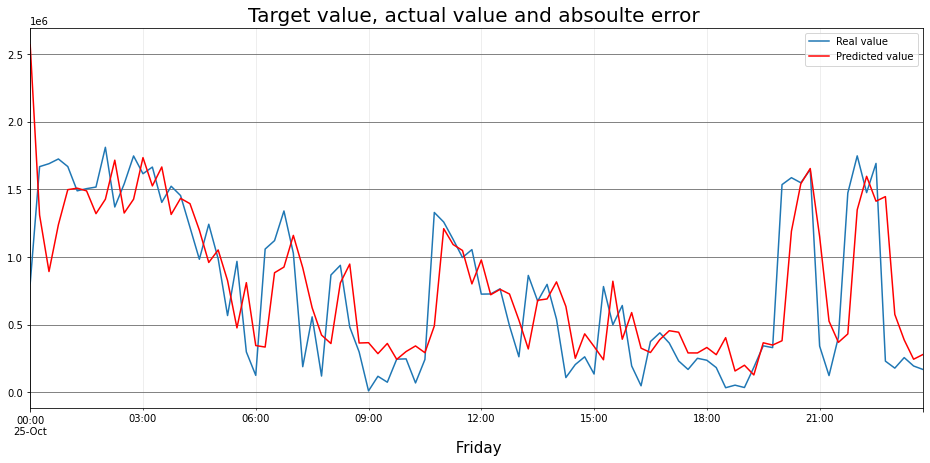

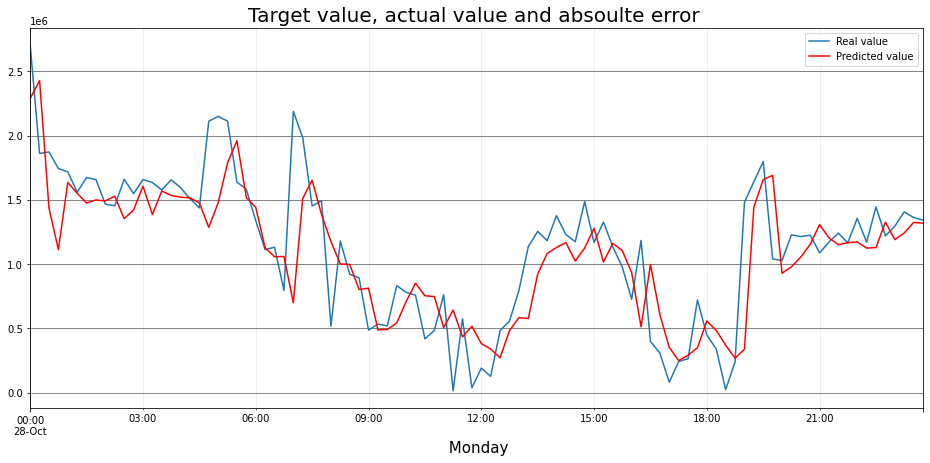

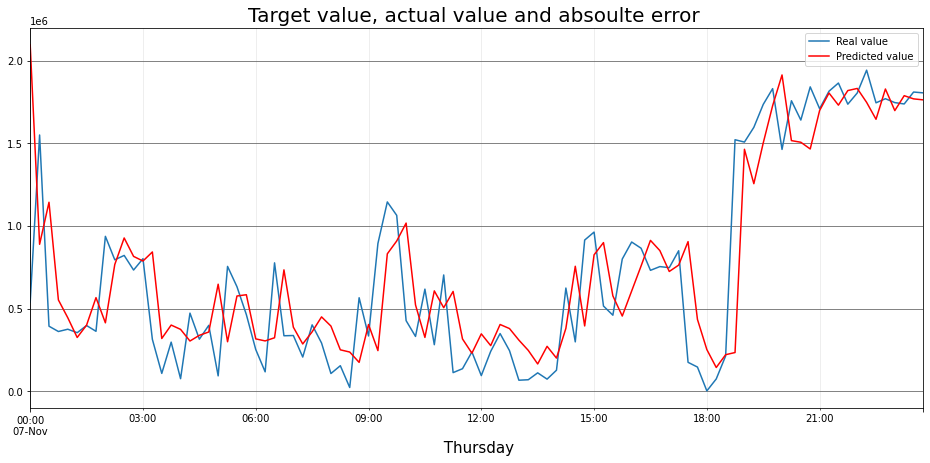

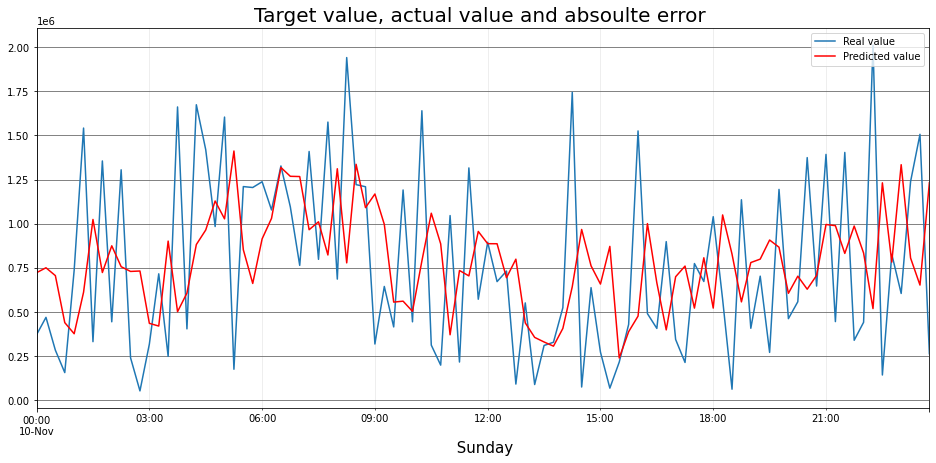

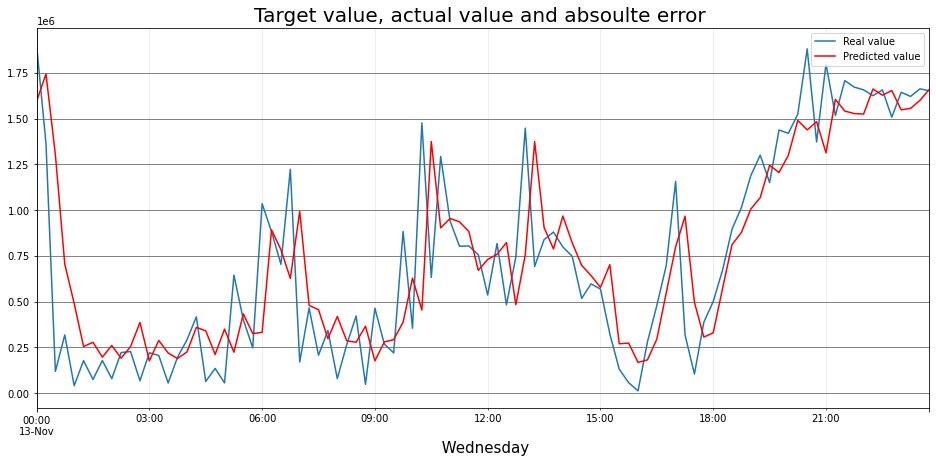

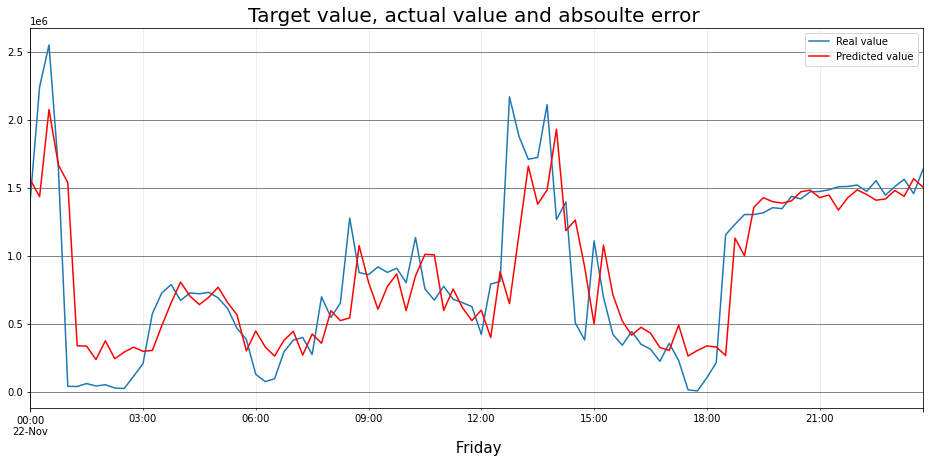

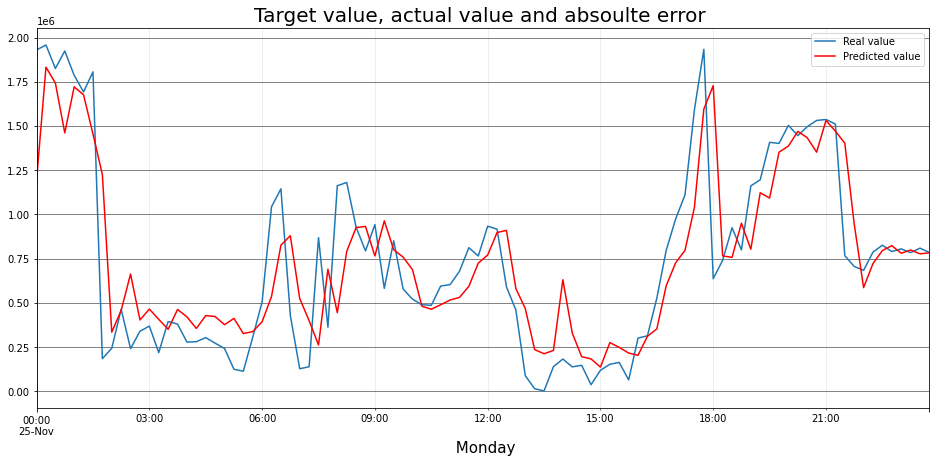

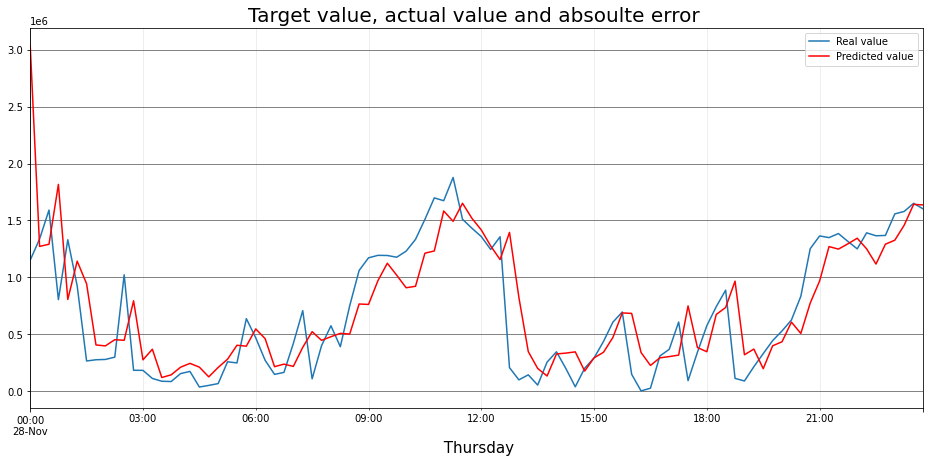

In [58]:
#dftestslice2=dftestslice2.reset_index()
#df_train=df_train.set_index('time')
#pred = model.fit(X_train,y_train).get_prediction(start=pd.to_datetime('2019-01-01'), dynamic=False)
#pred_ci = pred.conf_int()


for date, d in df_train.groupby(df_train['Dates']):
  fig, ax1 = plt.subplots(1,1,figsize=(16,7))
  ax1.set_title('Target value, actual value and absoulte error ',  fontsize=20)
  #ax1 = d['p_target'].plot(legend=True)
  ax1 = d['d_abs'].plot(legend=True,linestyle = '-',label='Real value')
  ax1 = d['prediction'].plot(color='red',legend=True,style='-',label='Predicted value')
  #ax1.set_xlabel(f",{d['Day']}")
  ax1.set_xlabel(f",{d['Day'].values[0]}".replace(',', ' '),fontsize=15)
  ax1.legend(loc='upper right')
  #ax1.set_xlabel(d['Day'])
  ax1.grid(b=True, which='major', color='#666666', linestyle='-') 
  ax1.grid(b=True, which='minor', color='#999999', linestyle='-',alpha=0.2)




   

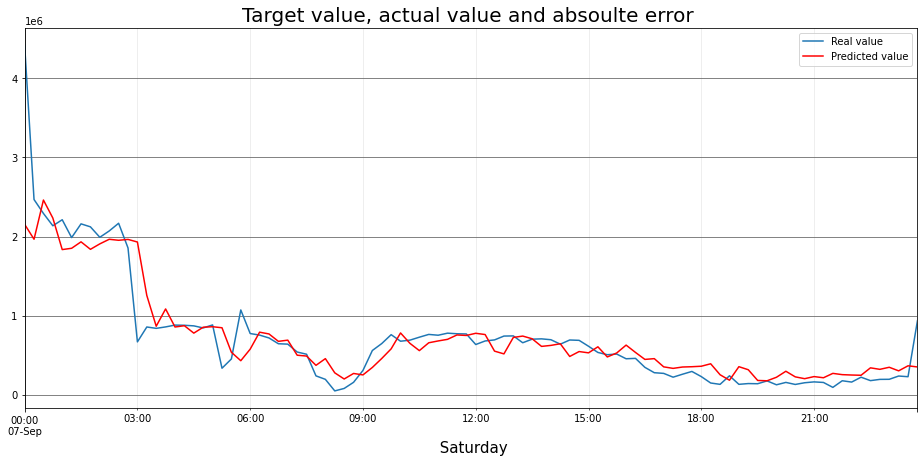

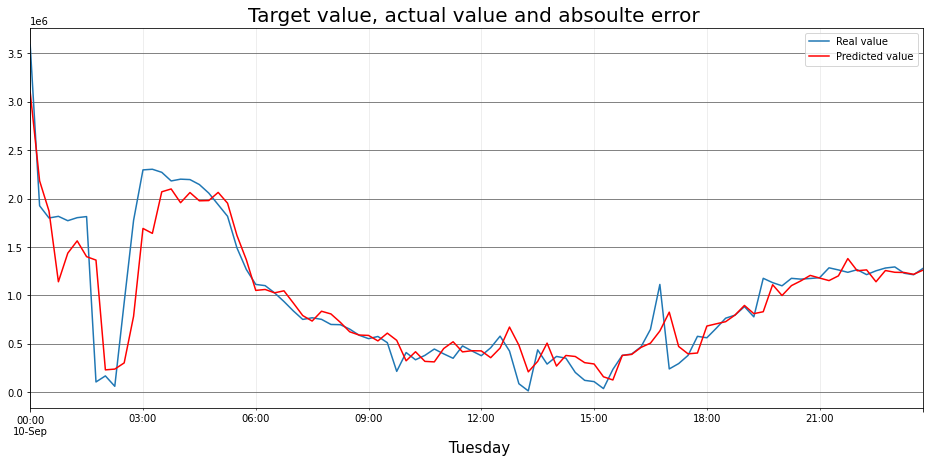

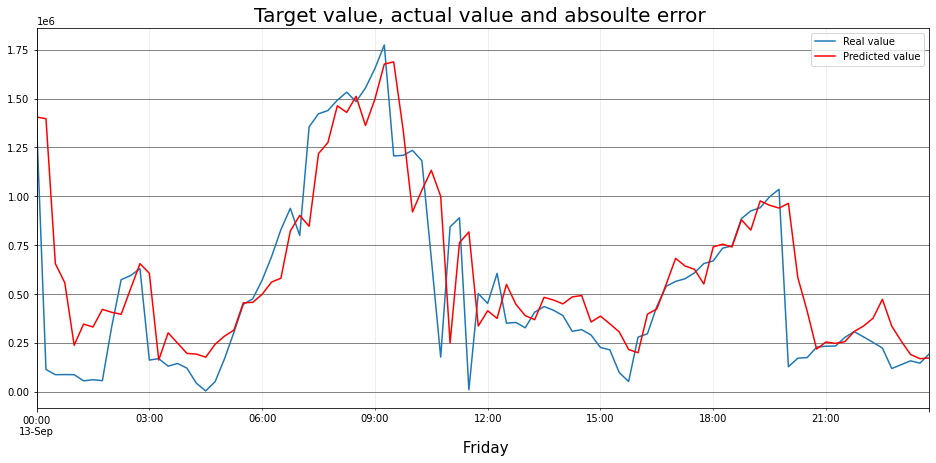

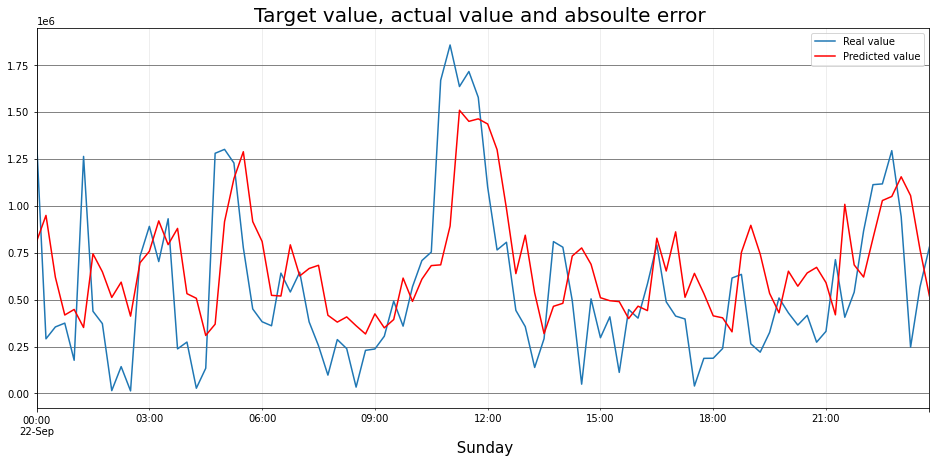

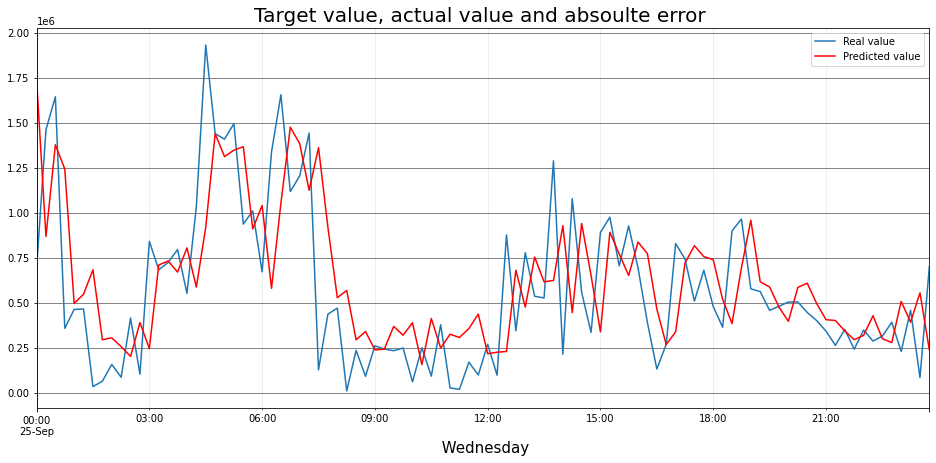

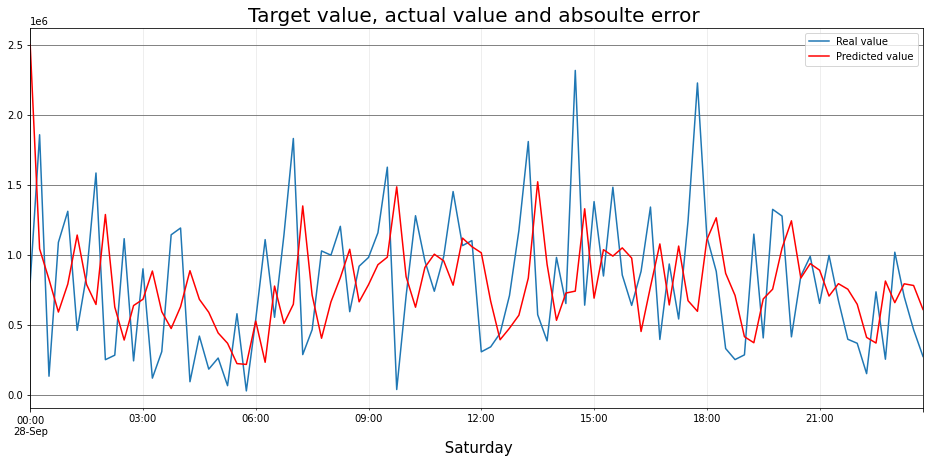

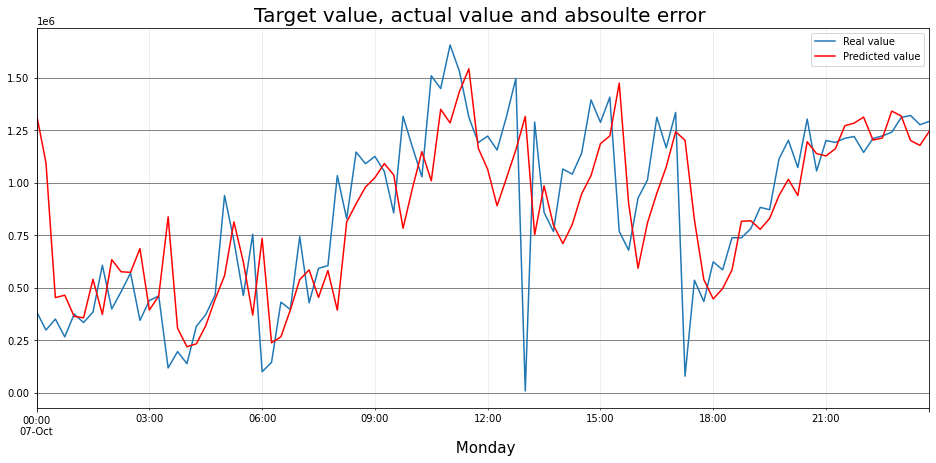

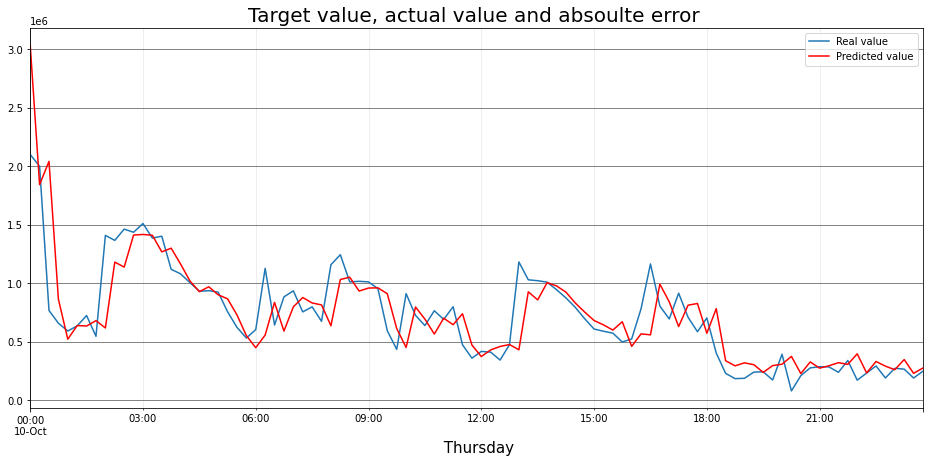

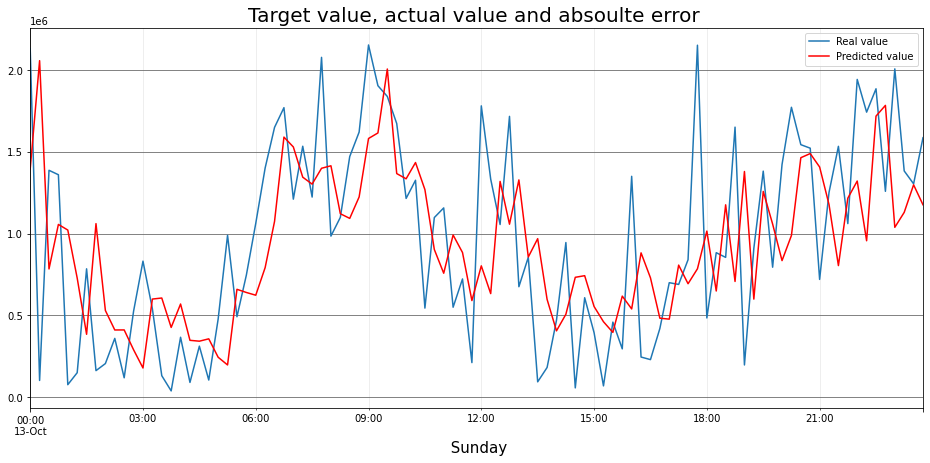

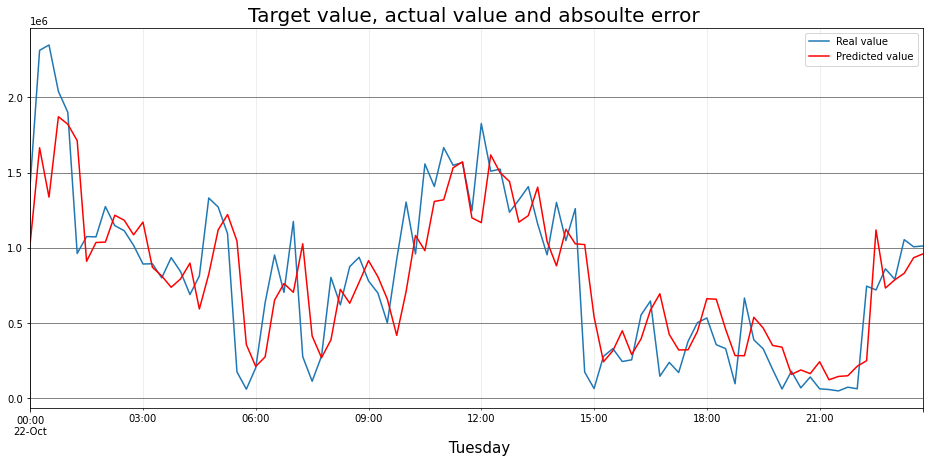

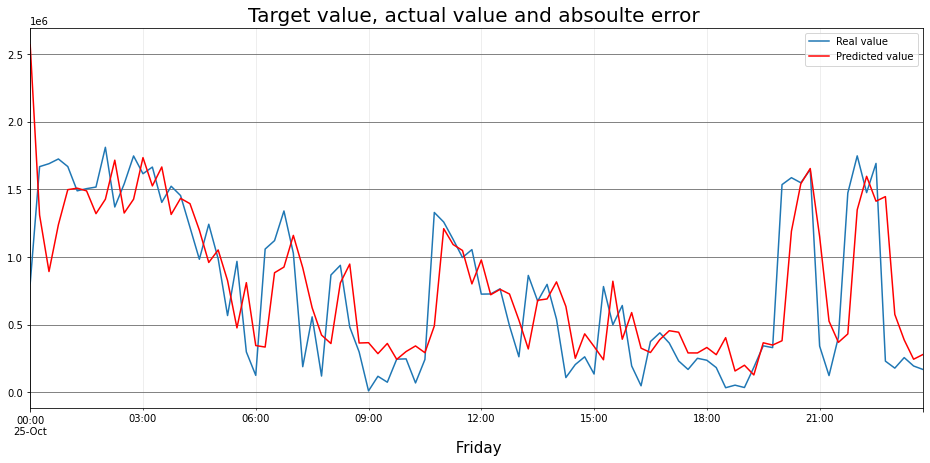

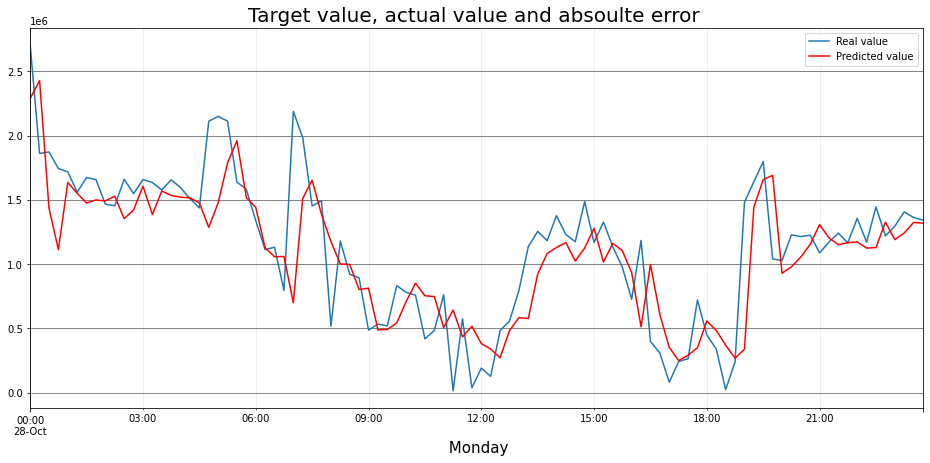

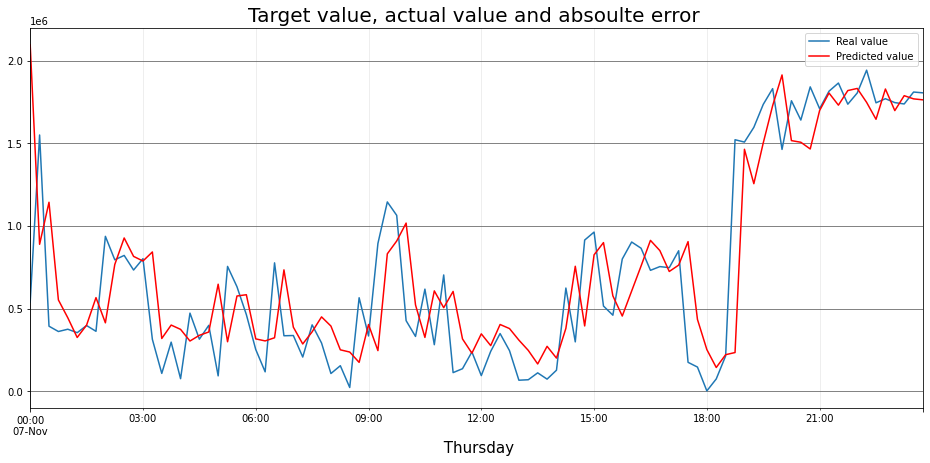

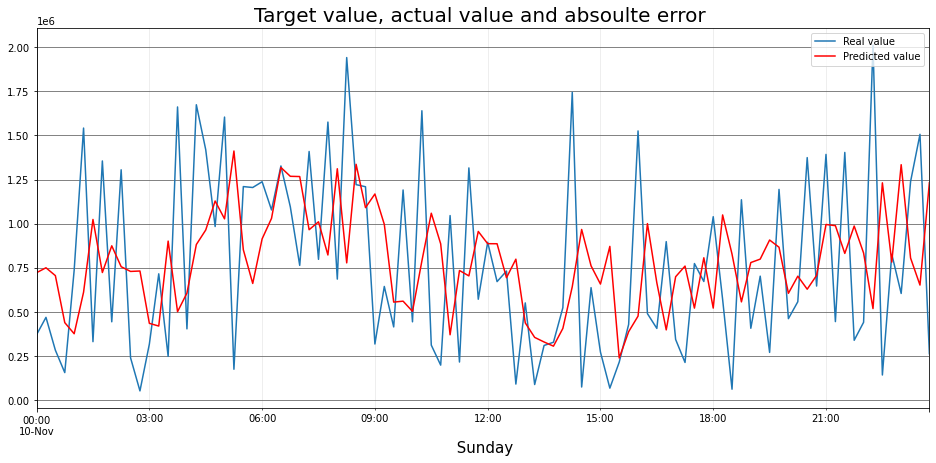

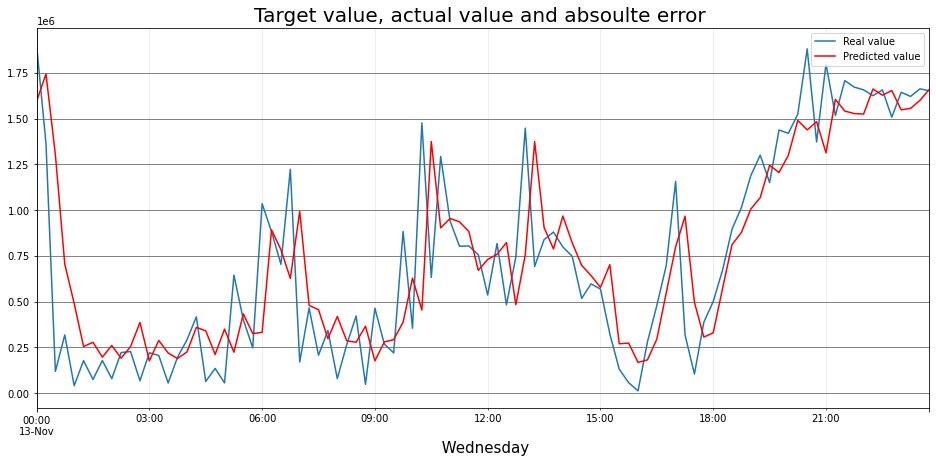

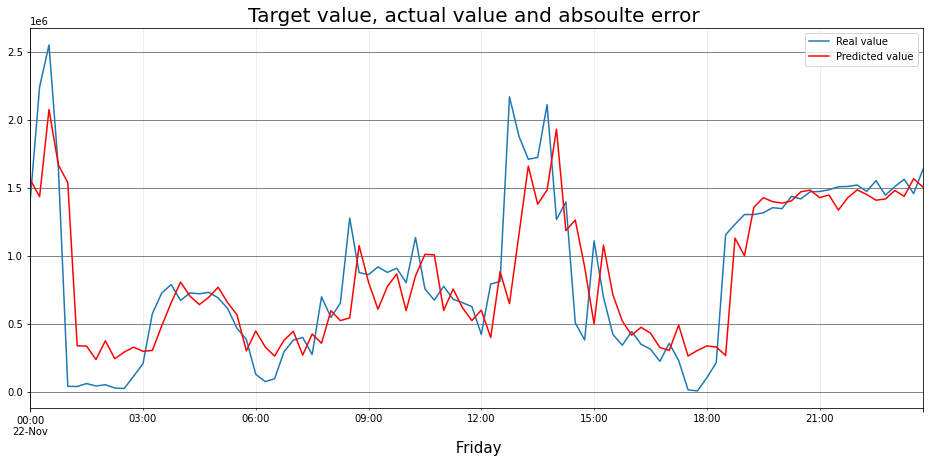

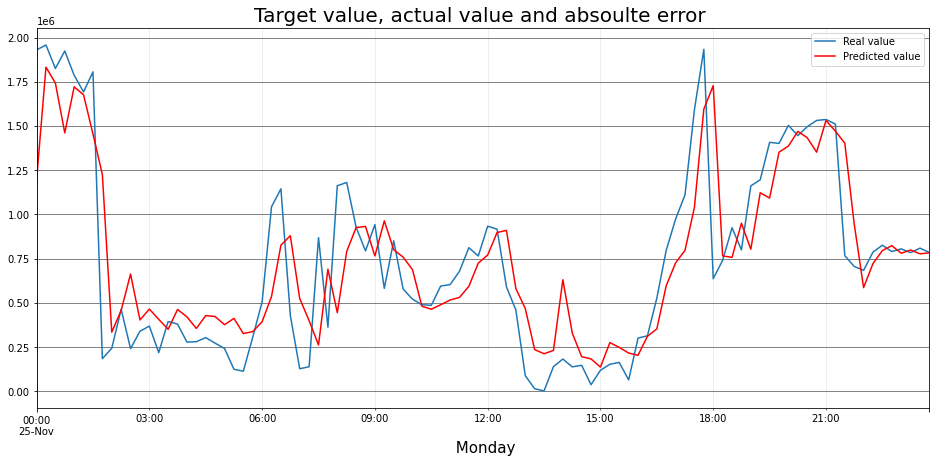

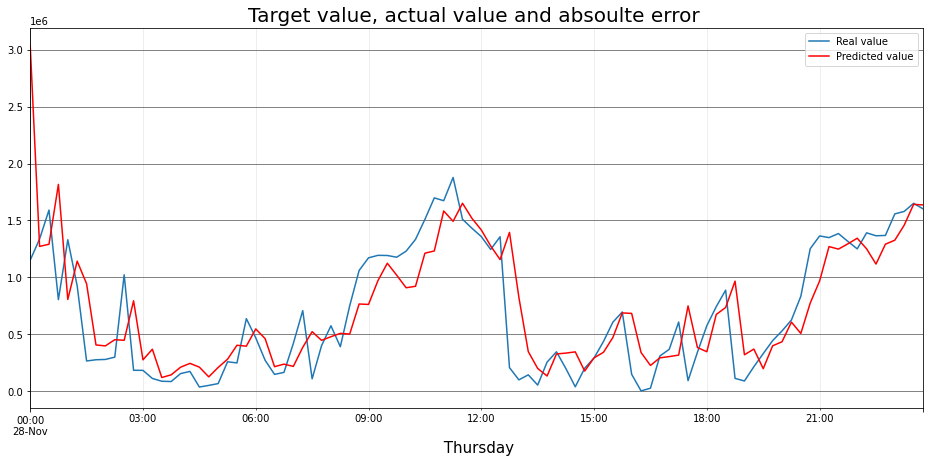

In [59]:
#dftestslice2=dftestslice2.reset_index()
#df_train=df_train.set_index('time')
#pred = model.fit(X_train,y_train).get_prediction(start=pd.to_datetime('2019-01-01'), dynamic=False)
#pred_ci = pred.conf_int()
#df_for_testing=df_for_testing.set_index('time')

for date, d in df_for_testing.groupby(df_for_testing['Dates']):
  fig, ax1 = plt.subplots(1,1,figsize=(16,7))
  ax1.set_title('Target value, actual value and absoulte error ',  fontsize=20)
  #ax1 = d['p_target'].plot(legend=True)
  ax1 = d['d_abs'].plot(legend=True,linestyle = '-',label='Real value')
  ax1 = d['prediction'].plot(color='red',legend=True,style='-',label='Predicted value')
  #ax1.set_xlabel(f",{d['Day']}")
  ax1.set_xlabel(f",{d['Day'].values[0]}".replace(',', ' '),fontsize=15)
  ax1.legend(loc='upper right')
  #ax1.set_xlabel(d['Day'])
  ax1.grid(b=True, which='major', color='#666666', linestyle='-') 
  ax1.grid(b=True, which='minor', color='#999999', linestyle='-',alpha=0.2)




   

In [ ]:
df_train=df_train.reset_index()

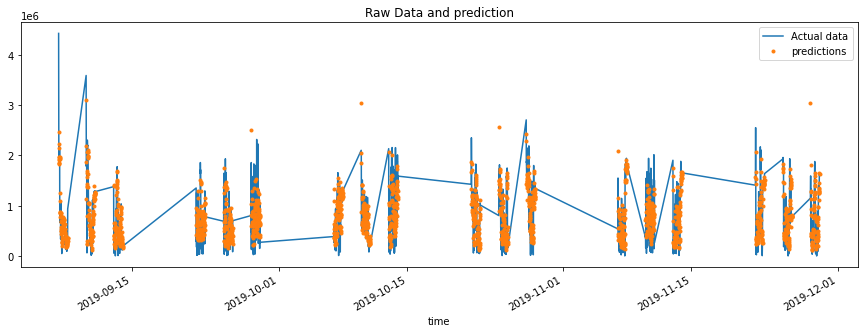

In [61]:
#predition ploted heir im Bezug auf unsere orginale Dataset
#df_train=df_train.reset_index()
#df_train=df_train.set_index('Dates')
ax=df_for_testing[['d_abs']].plot(figsize=(15,5))
df_for_testing[['prediction']].plot(ax=ax,style='.')
ax.set_title('Raw Data and prediction')
plt.legend(['Actual data','predictions'])
plt.show()